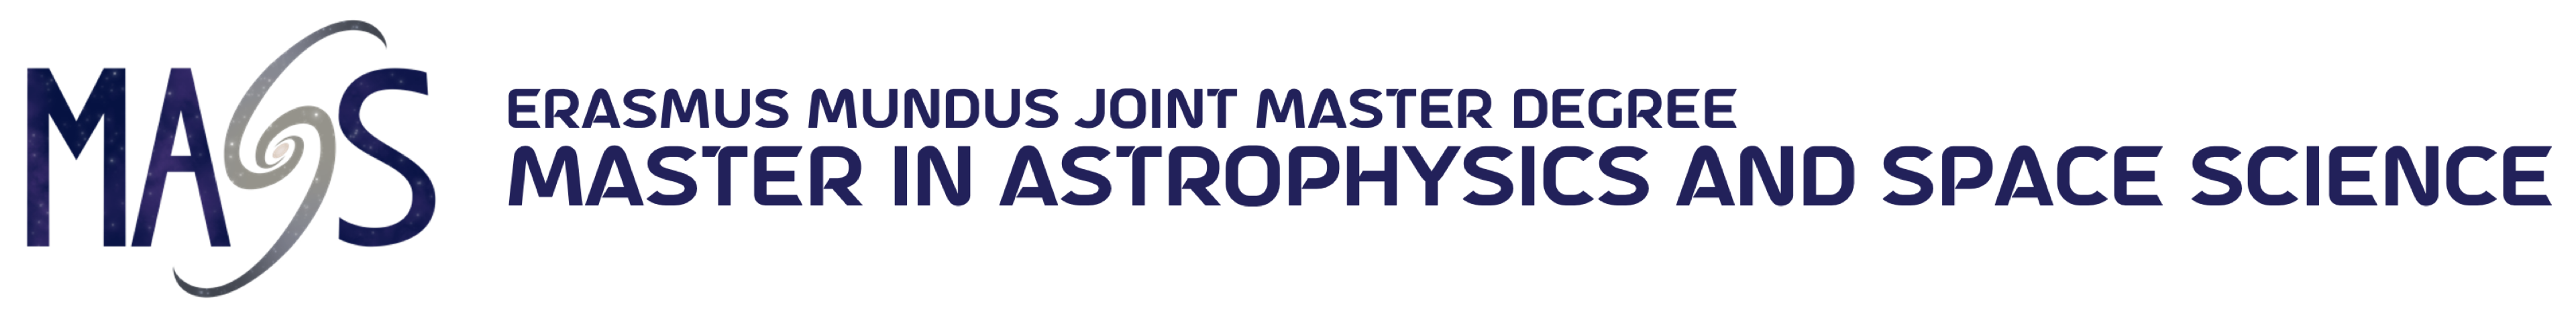

# IRAF Task: Spectroscopy - Data Reduction and Interpretation

## HW #4: IRAF Task: Spectroscopy - Data Reduction and Interpretation

14 Dec 2024

Student: Francesca Borg

Instructor: Prof. Dragana Ilić

This tutorial is on performing data reduction using IRAF following document _Task 11: Spectroscopy- Data Reduction and Interpretation_ by  A. Kaminski, J. Heidt, V. Pfeifer (March 5, 2021).

# IRAF Installation (4: Introductory remarks on IRAF)

```
set imtype = "FITS"
set dispaxis = 2
```

**Note:** use `epar` in front of commands to be able to fill in (edit) all parameters, and then type `:go` to run the task.

# 5. Data reduction: using Copernico dataset

The Copernico telescope with a mirror diameter of 1.82m can be used for photometry, spectroscopy, as well as for polarimetry. Different grisms can be applied to the Asiago Faint Object Spectrograph and Camera (AFOSC) for the spectroscopic observations. The specifics of the instrumental set-up are listed in Table 1, while the different exposures are summarized in Table 2. For the wavelength calibration two sets of emission spectra are available: three frames of a HgCd arc lamp, exposed at an exposure time of 60s, and three exposures of a Neon lamp, taken with 30s. These sets were recorded back-to-back with only a short time in between, so that they can be safely combined for the calibration (see Sec. 5.3 for details).

## 5.1 Calibration

First we will correct the raw images for **bias**, **trim them** to useful areas on the detector, and **normalize them** to the flat field lamp exposure taken in context of the observations.

### Bias Correction

A **bias** is typically 0~s exposures with the shutters closed, which can be used to determine the bias level.

**i. Combination of the bias images:**

Task:
```
noao
imred
ccdred
epar zerocombine
```

Fill in all parameters as in the tutorial:

```
input = @bias.txt
output = M_bias
ccdtype = EMPTY (remove default value 'zero')
rdnoise = rdnoise
gain = gain
```

Note that formatting as `@list.txt` means that the files input are not files, but rather a list of file names. Alternatively, you can feed all the file names in one by one separated by a comma.

Take a look at `M_bias` using `implot M_bias`:

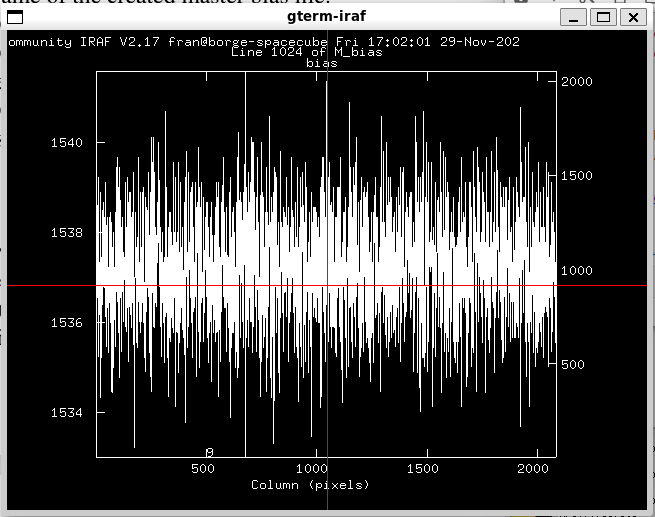

**ii. Applying the bias correction & Trimming:**

Use the master bias to correct all images and trim the original images to get rid of the under- and/or overscan areas of the detector.

Use the task:
```
noao
imred
ccdred
epar ccdproc
```

and fill in the parameters:
```
input = @all.txt
output = @all_bias.txt
ccdtype = EMPTY
fixpix = no
oversca = no
trim = yes
zerocor = yes
darkcor = no
flatcor = no
trimsec = [26:2065,7:2044] (values for Copernico data)
zero = M_bias
```

where `@all_bias.txt` is a list of the file names to assign to the bias-corrected output files, which we have to create manually, and looks as follows:

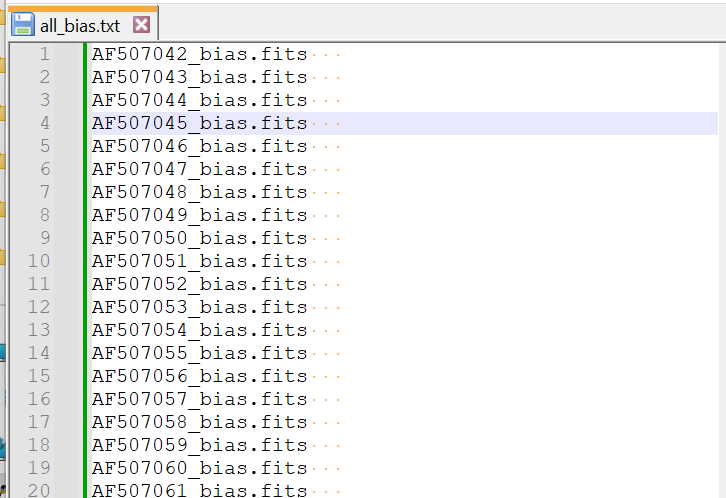

Running the task creates the new bias-corrected _.fits_ files named like `AF507055_bias.fits   `.


**Note**: we could also leave the `output` field empty and this would perform the bias correction in-place and overwrite the input _.fits_ files with the bias-corrected data.

### Visualisation of bias correction effects

Let us plot an image before and after bias correction (`AF507042.fits   ` and `AF507042_bias.fits   `) to visualise the effects:

**Before bias correction:**

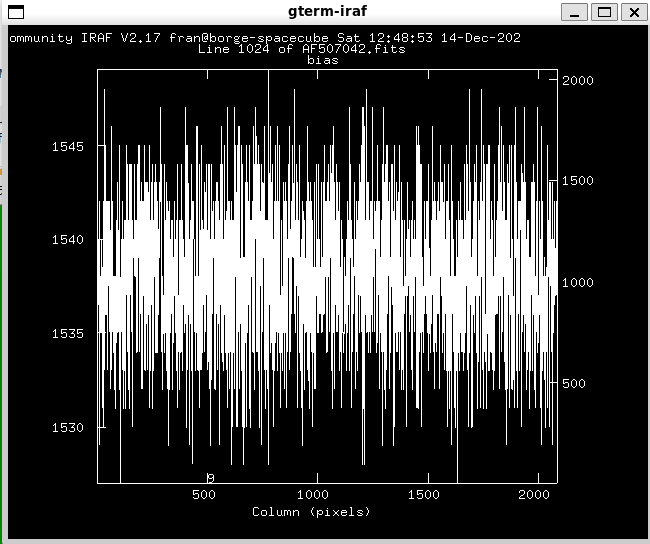

**After bias correction:**

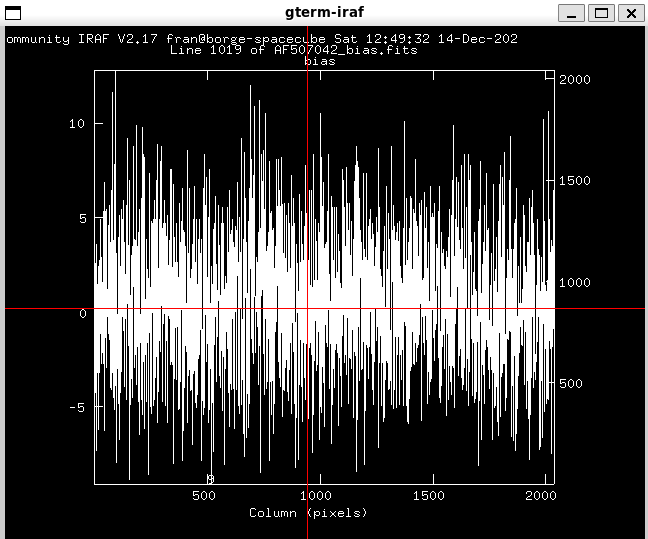

### Flat Normalization

We will combine all flat fields taken into a master flat, and then use this to correct our images.

**i. Combination of the flat images:**

We have 10 flat field images:
```
AF507058.fits   
AF507059.fits   
AF507060.fits   
AF507061.fits   
AF507062.fits   
AF507063.fits   
AF507064.fits   
AF507065.fits   
AF507066.fits   
AF507067.fits    
```

So, we now manually create a text file `flats_biascor.txt` with the list of bias-corrected flats to combine:

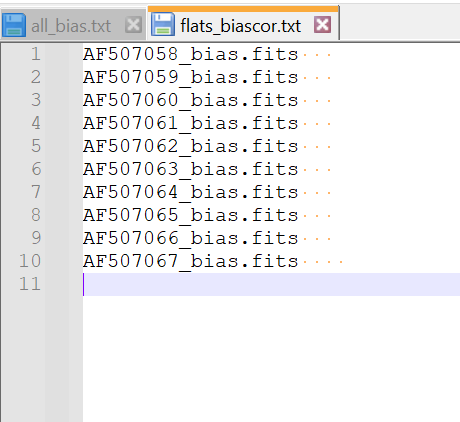

With this list, we can now run the task:
```
noao
imred
ccdred
epar flatcombine
```

with the following parameters:

```
input = @flats_biascor.txt
output = M_flat
reject = crreject
ccdtype = EMPTY
rdnoise = rdnoise
gain = gain
```

Which will create the master flat `M_flat` file, which we can take a look at using `implot`:

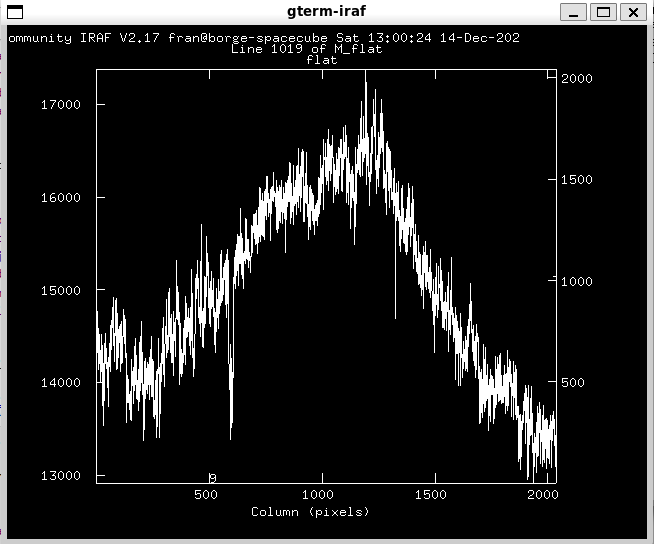

**ii. Fitting the flat lamp spectrum:**

The created `M_flat` will be used to determine and isolate the pixel-to-pixel variations to be corrected for. For this, the flat is corrected across the spatial axis, so that a 1D regression can be performed to fit the flat lamp's spectral distribution, and only the high frequency variations are left over.

Use the task:
```
noao
imred
kpnoslit
epar response
```

Then fill in the parameters as:
```
calibrat = M_flat
normaliz = M_flat
response = flat_response
interac = yes
functio = spline3
order = 3
```

When `interactive` is `yes`, you will be asked to verify - type `yes`.

**How to interactively fit the flat lamp spectrum:**

You will see a plot with collapsed flux on the y-axis vs. pixel dimension (position) on the x-axis. Dashed overplot depicts current fit, which you will fit to resemble the flat lamp spectrum. To modify fitting order, keep plotting window open, and type:

- `:o 5` to change to order = 5 and press `ENTER`.
- press `f` to fit it again.
- **Outliers** = single data points with significant deviations, can be eliminated by hovering the cursor on top and pressing `d` for delete. (Deleted 1 points are marked with an X).
- Once satisfied with results, press `q` to quit task.
If the fitting is sufficient, when the lower frequency variations are well resembled by the fitting curve.

The resuls from our fitting are:

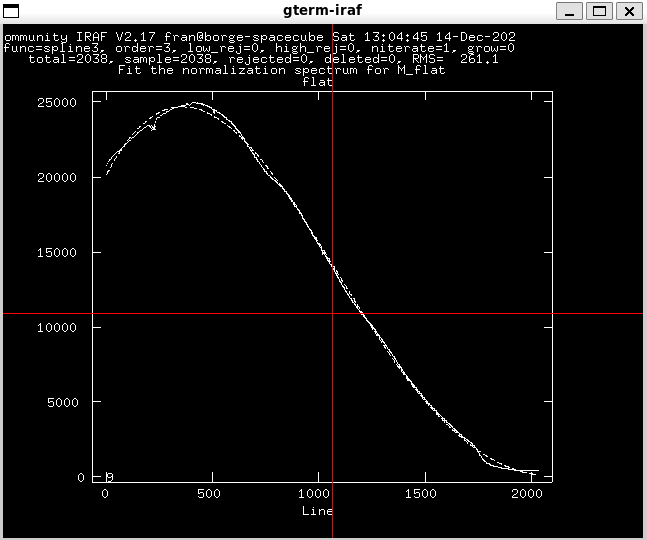

**iii. Applying the flat correction:**

The flat normalized variation map is now used to correct the science data for unwanted higher order variations. All features apparent in the flat field exposures, on top of the fitted lamp spectrum, will be corrected for.

Use the task:
```
noao
imred
ccdred
epar ccdproc
```

We manually create a list of output file names `all_flatcor.txt` containing all the filenames modified from `AF507042.fits   ` to `AF507042_flatcor.fits   `, which looks like the following:

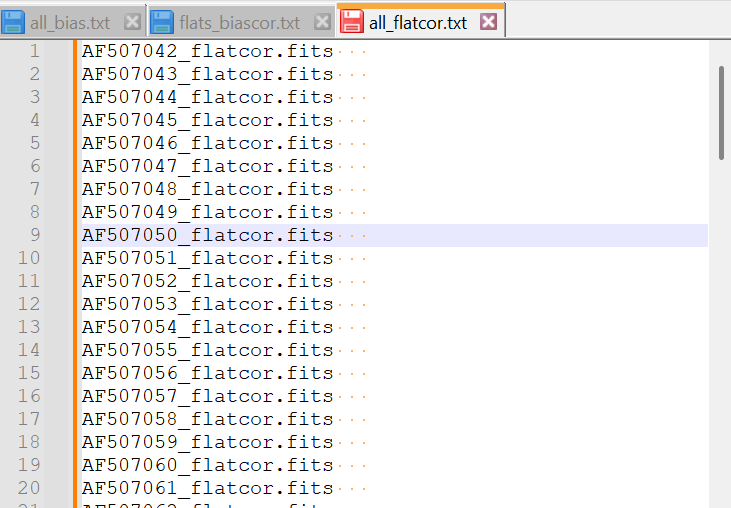

Now we can fill in and run the task with the following parameters:
```
input = @all.txt
output = @all_flatcor.txt
ccdtype = EMPTY
fixpix = no
oversca = no
trim = no
zerocor = no
darkcor = no
flatcor = yes
flat = flat_response (created in previous task)
```

### Visualisation of flat correction

Let us take a look on what this did to our images by plotting an image with only bias-correction, and another with bias and flat corrections.

**Before flat correction:**

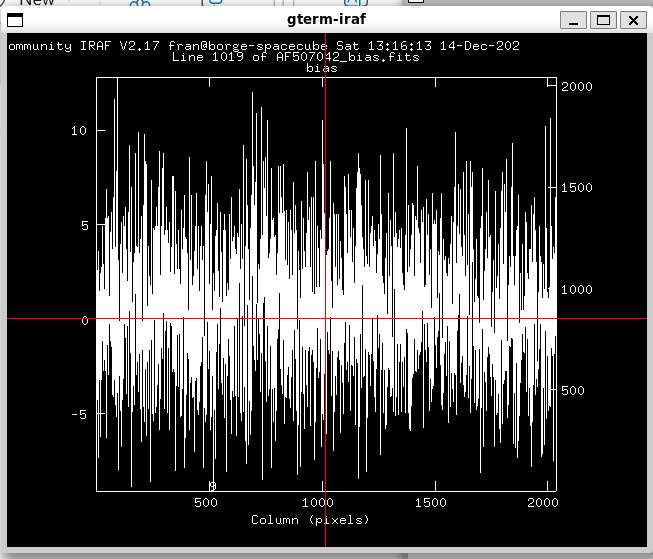

**After flat correction:**

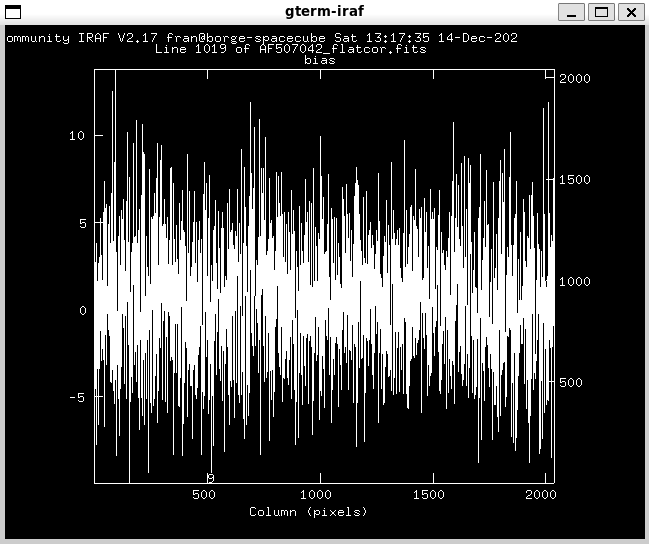

## 5.2 Spectrum Extraction

Extracting the 1-dimensional spectra from the 2-dimensional images.

**i. Image stacking**

First we combine all the observations/images of the same objects. The flat normalized target exposures will be combined to one image. Weighting will be applied according to the exposure times inside the file headers.

Use the task:
```
immatch
epar imcombine
```

and set the input parameters:
```
input = @obj1_flatcor.txt
output = obj1
combine = average
reject = crreject
weight = exposure
rdnoise = 0
gain = 1
```

where `@obj1_flatcor.txt` is a list of file names of the observations relating to Object1 (as defined in _Copernico_coded.txt_/refer to Appendix), after bias and flat corrections.

The images of Object1 are the following three:
```
AF507069.fits
AF507070.fits
AF507071.fits
```

So we create the text file as follows:

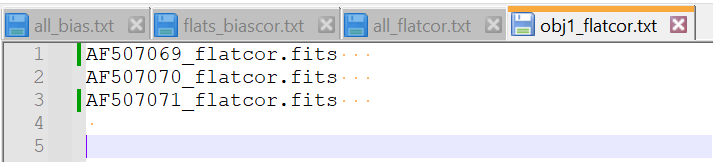

Running the task gives the following output:

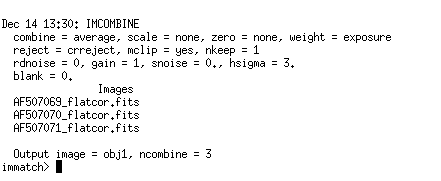

### Visualisation

Let us plot the output file `obj1.fits` to observe the effects:

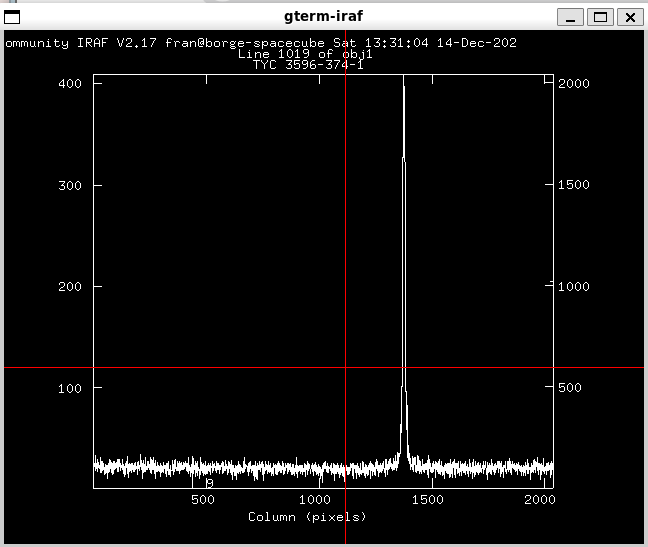

**ii. Spectrum extraction**

In the raw images, the spectra follow a distinct trace along the dispersion direction. In this task, we search for this trace in the target image. First, we sum the pixel intensities along the dispersion acis to find the rough position of the spectrum. Then, we place the aperture on top of the spectrum and trace the spectrum, fitting by a smooth function which is used for the final extraction. During the extraction, the background is also modeled and subtracted from the flux. Therefore, the background level is sampled in a specific region around the aperture, defined by the parameter `b_sampl`. The background might be overestimated if the regions are chosen too close to the target, and would need to be modified.

We use the task:
```
noao
imred
kpnoslit
epar apall
```

and submit the parameters:

```
input = obj1
output = obj1_spec
recente = yes
resize = no
edit = yes
trace = yes
b_funct = chebyshev
b_order = 2
b_sample = -70:-40,40:70
b_naver = -15
b_niter = 2
width = 5
radius = 5
nfind = 1
bkg = yes
t_nsum = 5
t_step = 5
t_funct = spline3
t_niter = 1
backgro = fit
weights = variance
clean = yes
```

The fitting procedure looks like the following:

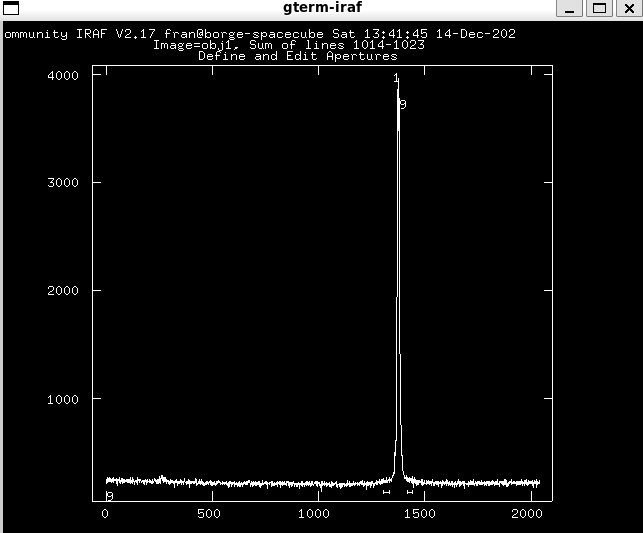

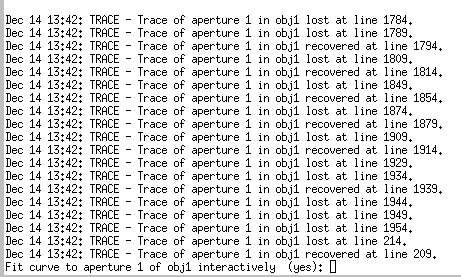

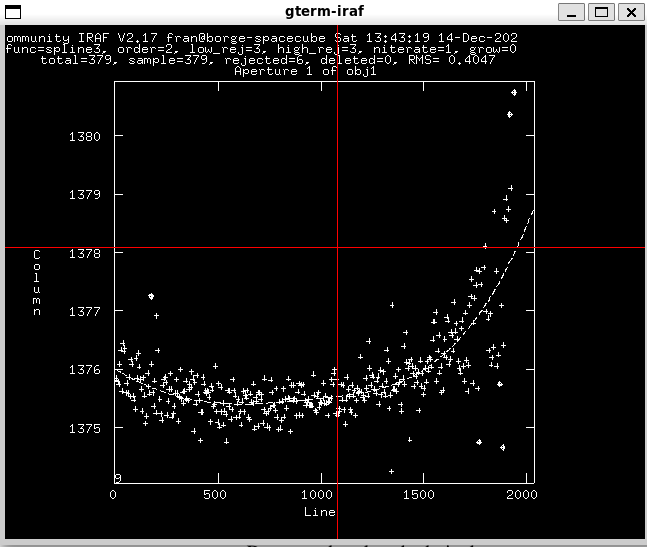

We interactively fit by deleting outliers (`d`, now marked with an X) and refitting the function (`f`) as before:

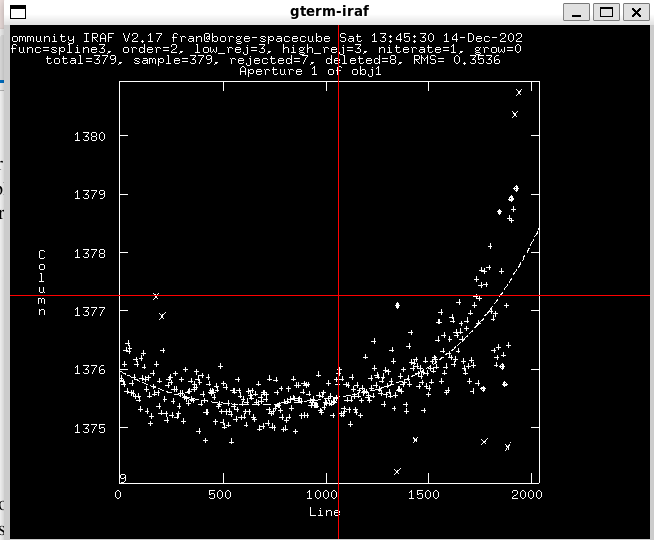

and our final extracted spectrum looks like this:

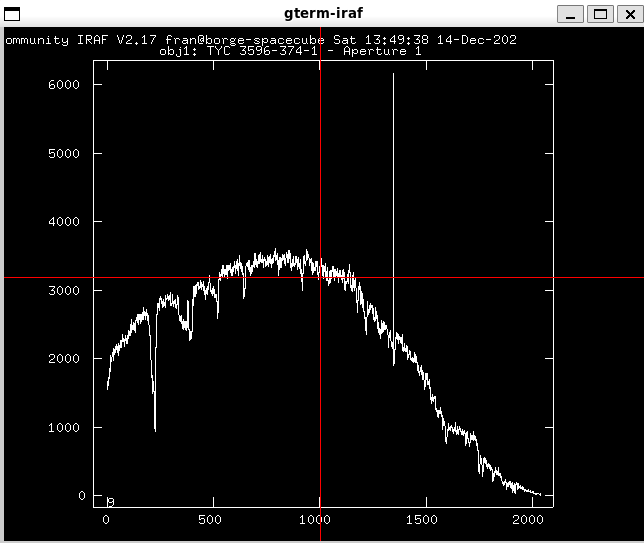

**Note:** Plotting the spectrum can also be done using `noao -> imred -> kpnoslit -> splot obj1_spec`. In `splot` you can zoom in by ”z” and move left/right using ”,” and/or ”.”. Redraw the graph in full scale again with ”c”.

**For a different target object:**

Now, extract the spectrum for a different type of object: object 3.

**i. Image stacking**

Again, use the task:
```
immatch
epar imcombine
```

and set the input parameters:
```
input = @obj3_flatcor.txt
output = obj3
combine = average
reject = crreject
weight = exposure
rdnoise = 0
gain = 1
```

where `@obj3_flatcor.txt` is a list of file names of the observations relating to Object3 (as defined in _Copernico_coded.txt_/refer to Appendix), after bias and flat corrections.

The images of Object3 are the following three:
```
AF507075.fits
AF507076.fits
AF507077.fits
```

So we create the text file as follows:

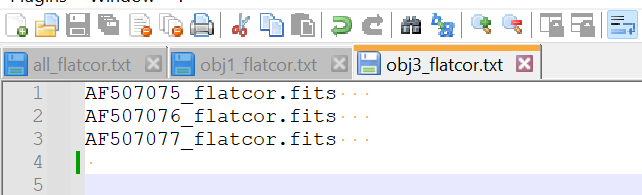

Running the task gives the following output:

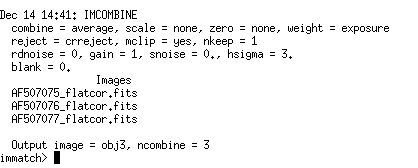

### Visualisation

Let us plot the output file `obj3.fits` to observe the effects:

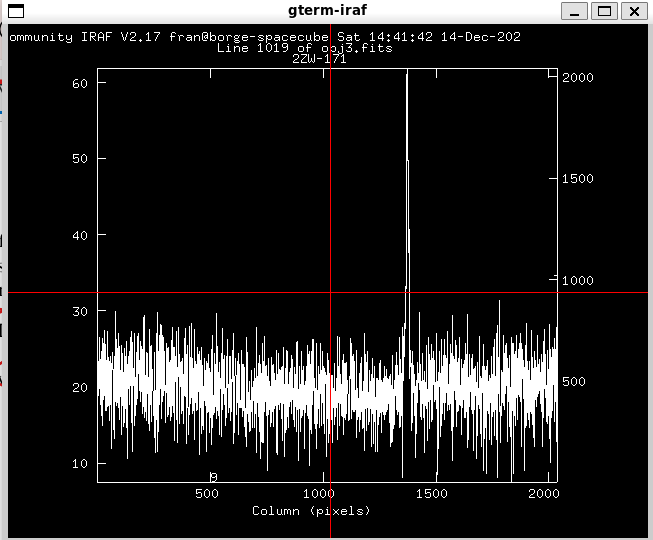

**ii. Spectrum extraction**

We use the task:
```
noao
imred
kpnoslit
epar apall
```

and submit the parameters:

```
input = obj3
output = obj3_spec
recente = yes
resize = no
edit = yes
trace = yes
b_funct = chebyshev
b_order = 2
b_sample = -70:-40,40:70
b_naver = -15
b_niter = 2
width = 5
radius = 5
nfind = 1
bkg = yes
t_nsum = 5
t_step = 5
t_funct = spline3
t_niter = 1
backgro = fit
weights = variance
clean = yes
```

The fitting procedure looks like the following:

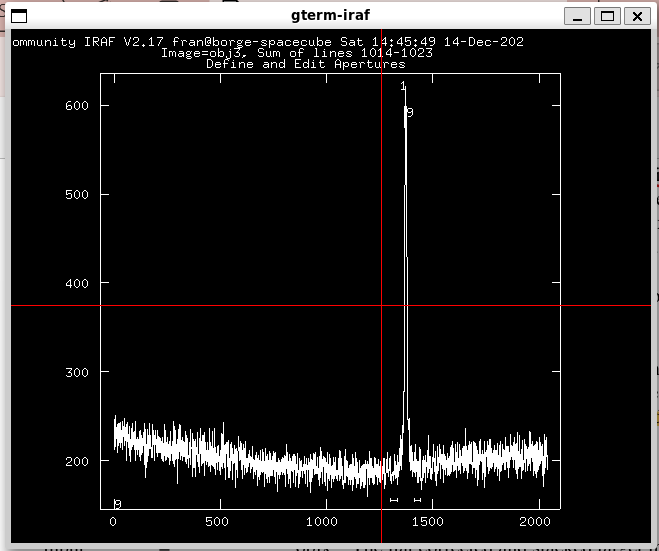

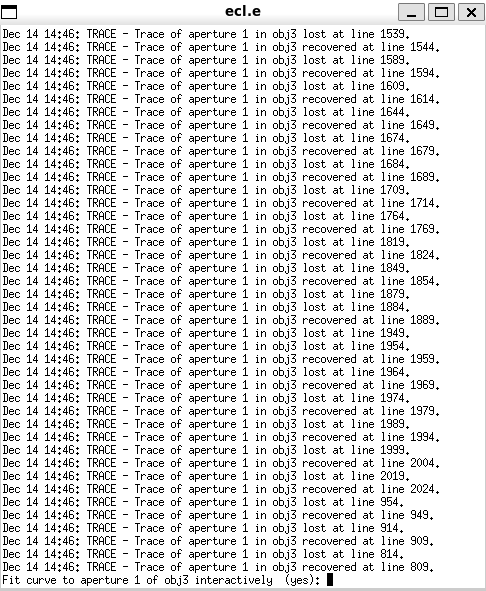

We interactively fit by deleting outliers (`d`, now marked with an X) and refitting the function (`f`) as before:

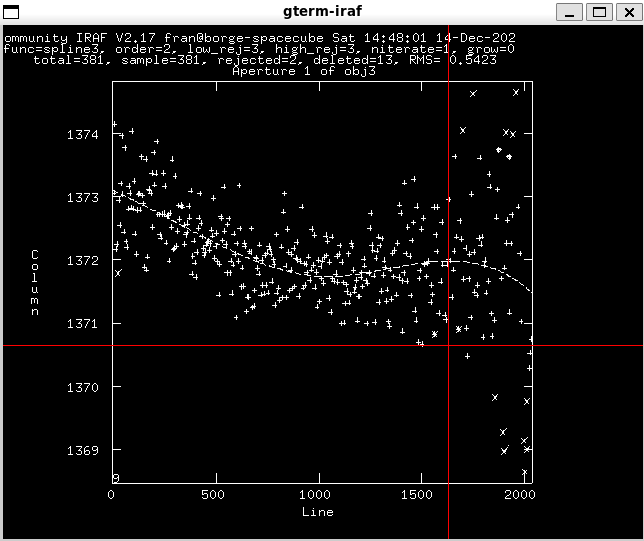

and our final extracted spectrum looks like this:

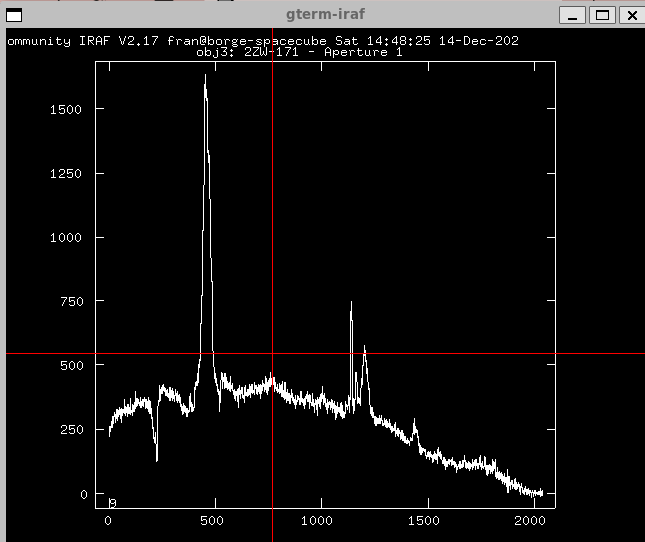

## 5.3 Wavelength Solution

Up until now, out spetcra have been plotted as flux against pixels along the dispersion direction because there is no wavelength information available in the data. In this task, we will find the wavelength solution to the x-axis by creating a mapping from pixel to wavelength space. For this, we need spectra with lines at well known positions, for which we can use the emission line spectra of arc lamps taken during observations.

### Processing emission lamp spectra

First, we need to extract the emission line spectra in the same format as the target spectra. Each lamp also has several exposures, which need to be combined. Then, the combined spectra need to be inspected, and the emission lines identified by providing their wavelengths at rest frame, in order to obtain the wavelength solution.

**i. Extraction of lamp spectra**

Note that for the Copernico telescope, the relevant lamps are Ne and HgCd.

We use the command:

```
noao
imred
kpnoslit
epar apall
```

First, let's perform the task for the **Ne** lamp.

We need to create a file `ne_flatcor.txt` which contains the following list of filenames containing images of the Ne lamp which are further bias and flat corrected:
```
AF507052.fits   
AF507053.fits   
AF507054.fits
```

We create the relevant text file as follows:

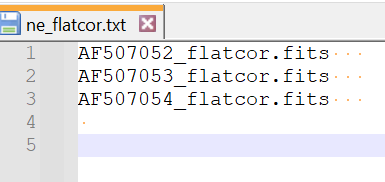

and also a txt file `ne_spec.txt`, which is a list of filenames to assign to the outputted extracted spectra:

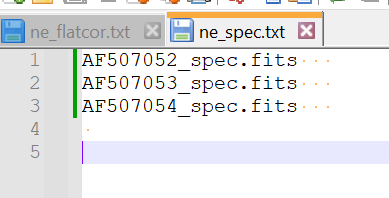

Now we can run the task with the following parameters to extract the Ne lamp spectrum:
```
input = @ne_flatcor.txt
output = @ne_spec.txt
referen = obj1
recente no
resize = no
edit = no
trace = no
bkg = no
backgro = none
```

We obtain spectra like the following: (below spectrum is plotted for the last image file)

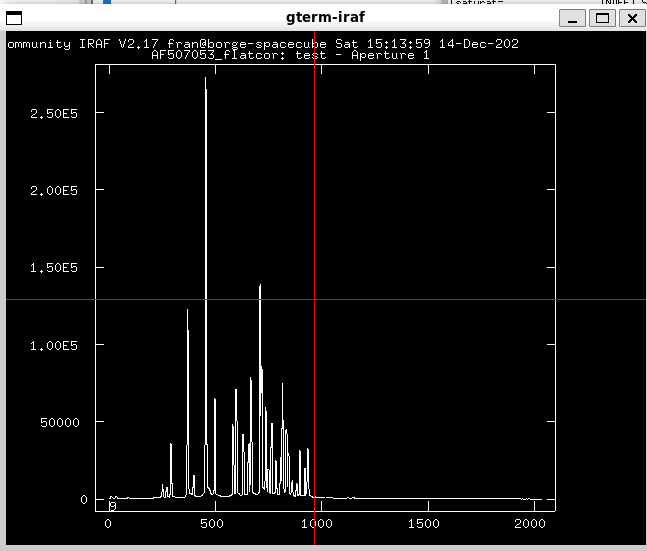

We now repeat this process with the **HgCd** lamp, where the relevant image files are:
```
AF507055.fits   
AF507056.fits   
AF507057.fits   
```

We create the corresponding text files for input/output filenames:

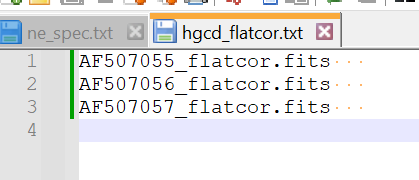

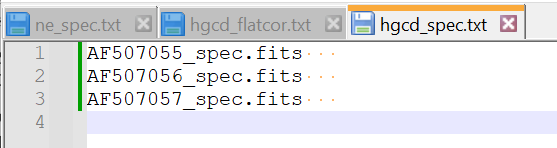

And run the task with the following parameters for the HgCd lamp:
```
input = @hgcd_flatcor.txt
output = @hgcd_spec.txt
referen = obj1
recente no
resize = no
edit = no
trace = no
bkg = no
backgro = none
```

We obtain spectra like the following: (below spectrum is plotted for the last image file)

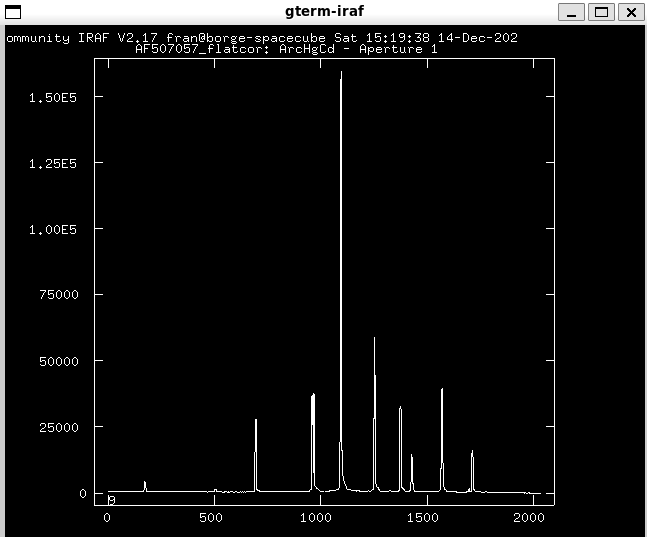

**ii. Combining lamp spectra:**

For the 1.82m Copernico data set two different arc lamps were used. As the Ne lamp exhibits emission lamps mostly at one side of the spectrum, while the HgCd lamp on the other, in this case it is in fact necessary to combine them to one final spectrum.

To combine this we use the task:
```
noao
imred
specred
epar scombine
```

To combine all the spectra from all images of both the Ne and HgCd lamps, we have to create a complete list of filenames `lamps_specs.txt` as follows:

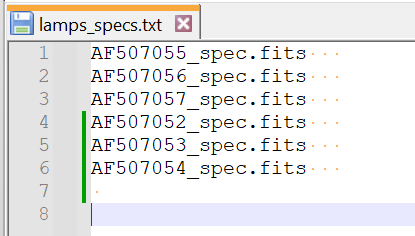

We run the task with the following parameters set:
```
input = @lamps_specs.txt
output = lamps_combined
scale = none
zero = none
weight = none
```

Which creates the following output:

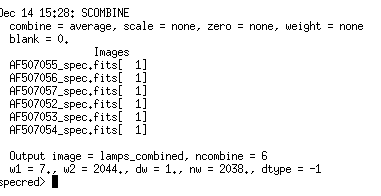


### Visualisation

Let's take a look at this combined spectrum using `splot`:

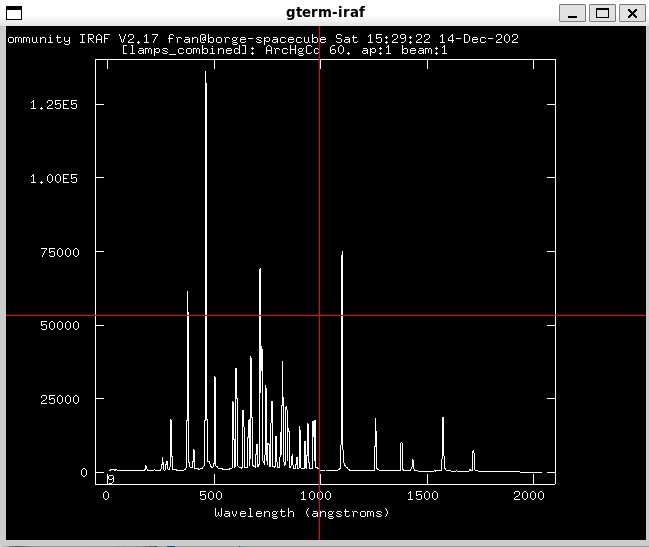

**iii. Line identification & wavelength fitting**

To find the correct wavelength fit, we compare the combined lamp spectrum to a given reference to identify the emission lines.

Use the task:
```
noao
imred
kpnoslit
epar identify
```

and the parameters:

```
images = lamps_combined
coordli = EMPTY
fwidth = 7.5
cradius = 5.
thesho = 10.
functio = spline3
order = 3
```

The lamp spectrum is plotted, we use a references for line identification (e.g. pg 25 of the tutorial). In order to enter a particular line’s wavelength, we move the crosshair to center it on the line. Press `m` to mark it, then enter the wavelength of the line in units of Angstrom and press ENTER.

**Note:** If the plot is too small, expand the window and press `r` to redraw.

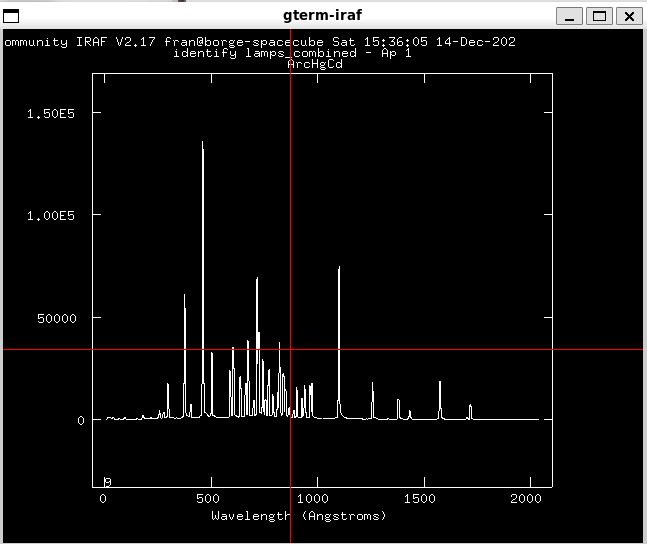

Identify 5 - 10 lines using the reference image:

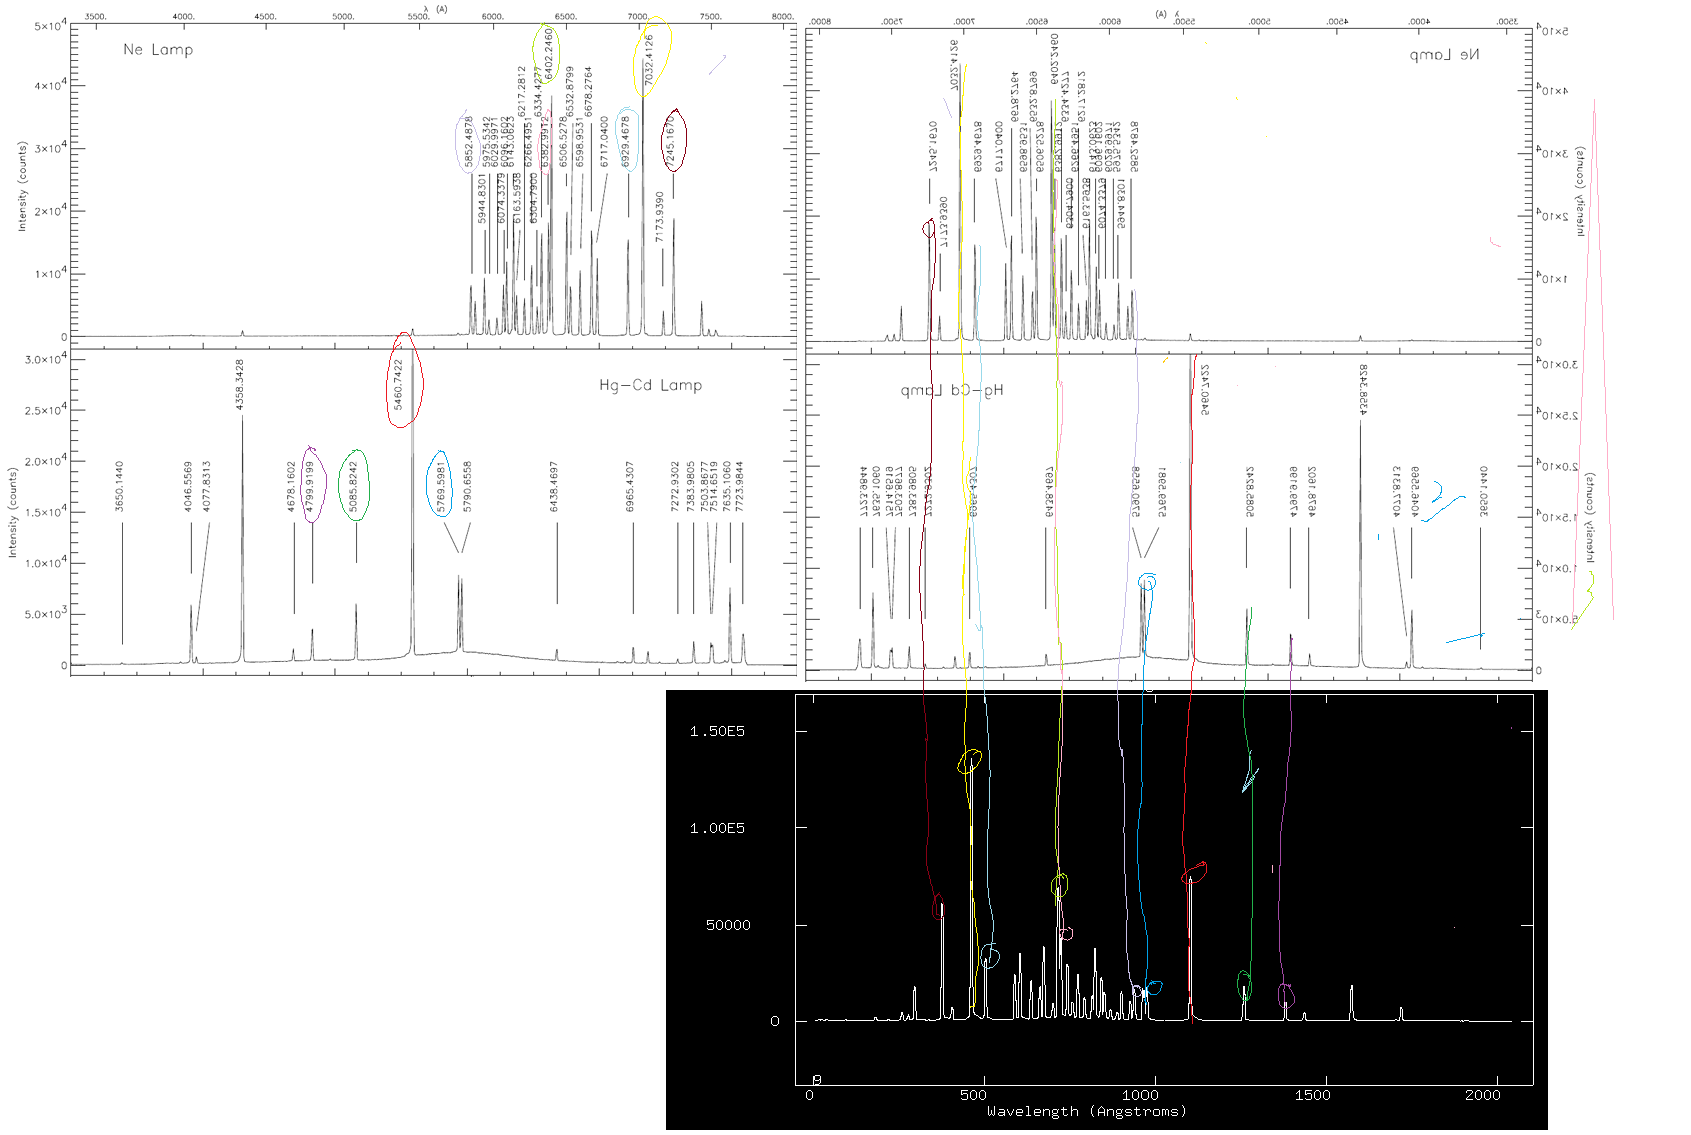

and annotate them on the plot:

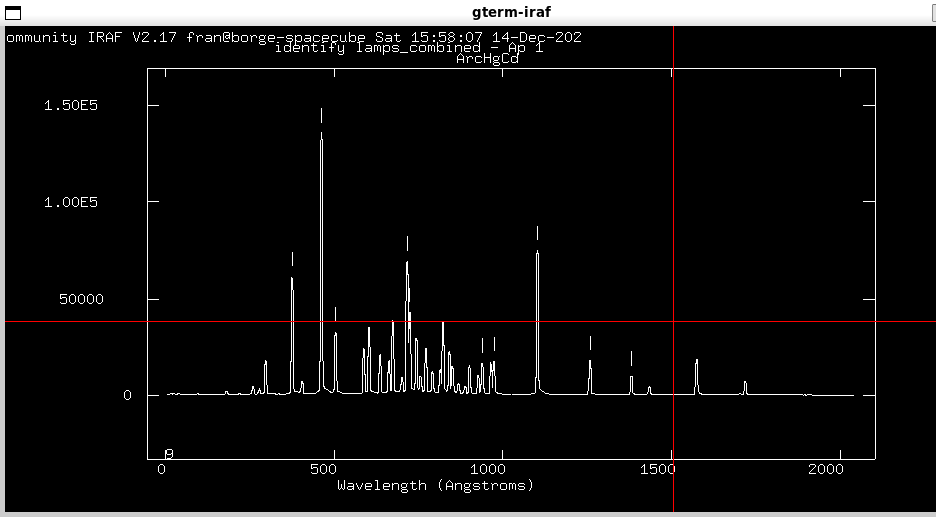

while entering the corresponding line wavelengths for each mark:

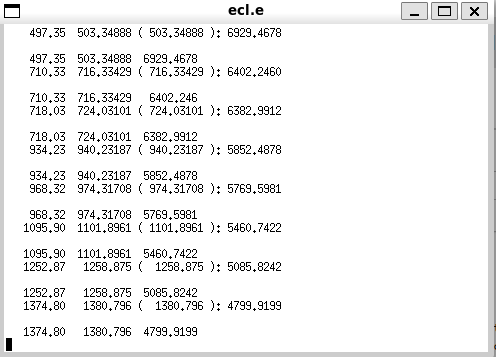

Then, press `f` to start the fitting process, at which point the corresponding residual plot will be shown:

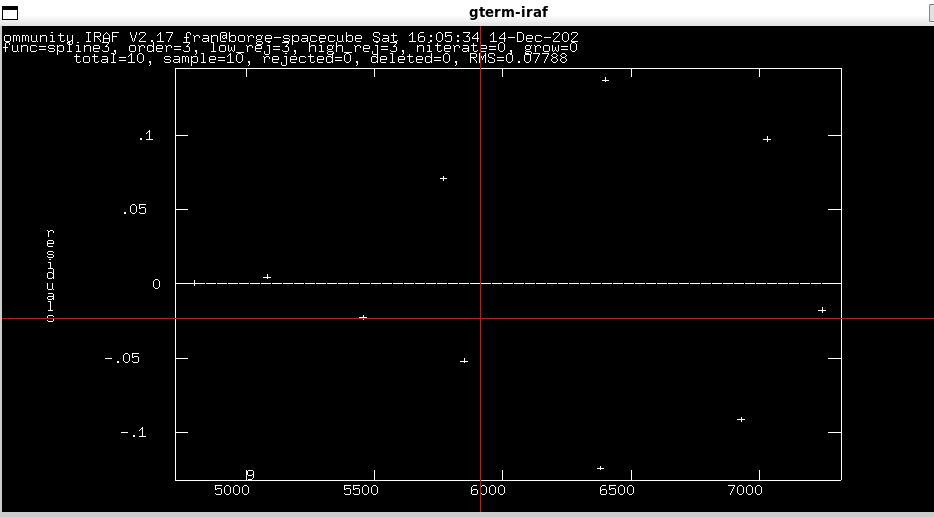

Here, we are again able to fit the line interactively by deleting outliers (`d`) and updating the fit (`f`). When finished, press `q` to quit and end the process.

**Wavelength mapping in science spectra**

Now, we have a proper wavelength solution, which now needs to be applied to the extracted science target spectra.

**i. Editing file header**

Use the command:

```
imutil
epar hedit
```

And use the parameters:
```
images = obj1_spec
fields = REFSPEC1
value = lamps_combined
add = yes
```

And we achieve the following:

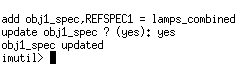

**ii. Applying the wavelength solution**

Using package:
```
noao
imred
kpnoslit
epar dispcor
```

and the parameters:
```
input = obj1_spec
output = obj1_speccor
```

Output:

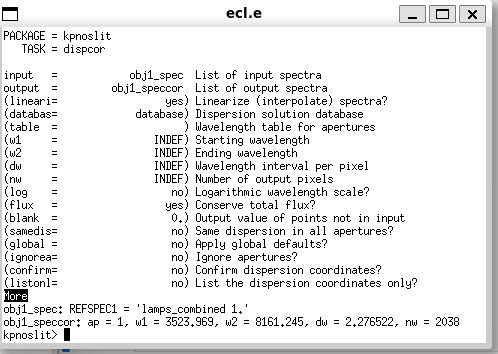

Now, our spectrum when running `splot` shows the spectrum plotted vs. wavelength instead of pixels.

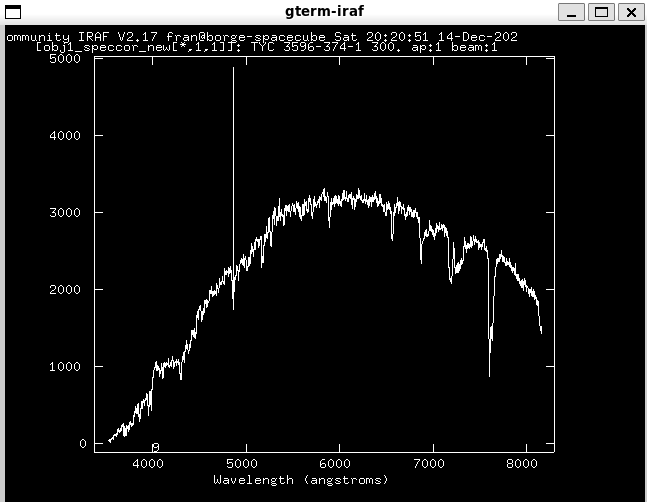

# 5.4 Flux Calibrations

**Instrumental Response**

**i. Setting up flux calibration**

For this step, we need to identify first the object to be used for the flux calibration:

From the table describing the objects in the Copernico dataset (Table 2)

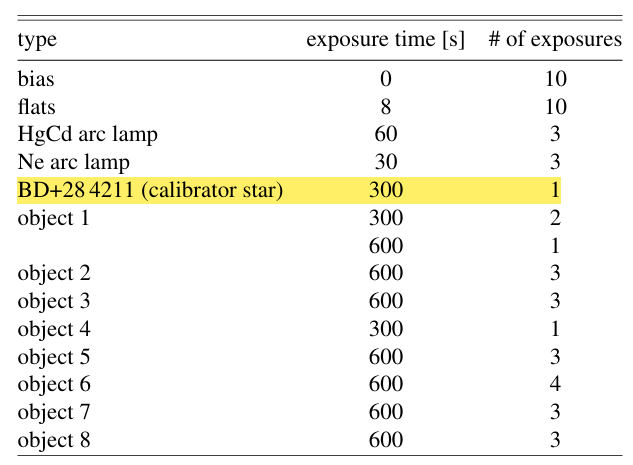

we can see that the star BD+28 4211 is the standard star to be used for calibration, which from Copernico_coded.txt, we know is stored in the file _AF507068.fits_

However, we must first extract the spectrum using the previous method:

```
noao
imred
kpnoslit
```
First, reset all parameters to default by using `unlearn apall`, and then run:

```
epar apall
```

and use the parameters:

```
input = AF507068.fits
output = calibstar_spec
recente = yes
resize = no
edit = yes
trace = yes
b_funct = chebyshev
b_order = true
b_sample = -70:-40,40:70
b_naver = -15
... etc
```

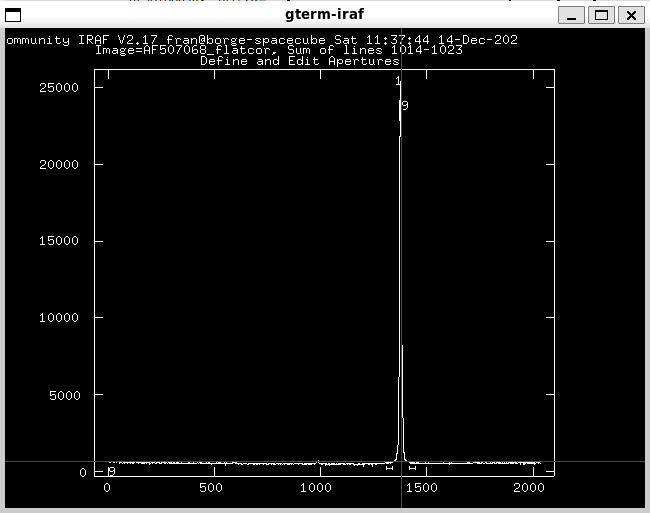


and we get the following:

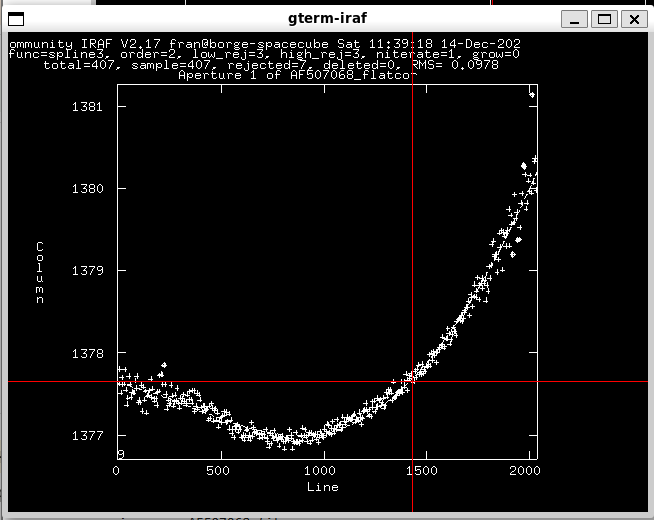

and the spectrum is:

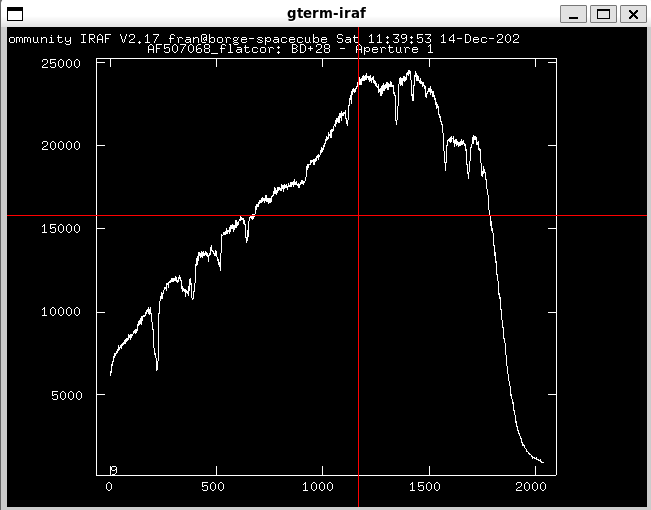

We also apply the wavelength solution found previously to obtain the spectrum `calibstar_speccor` across wavelength in Angstrom (illustrated below using `splot`):

First, we have to edit the file header:

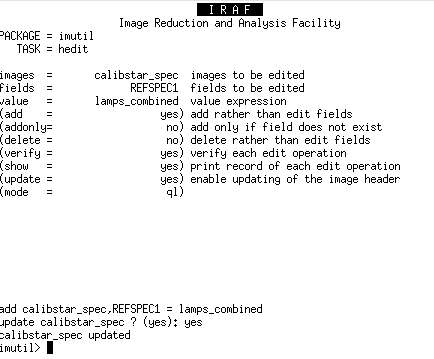

Then, to apply the wavelength solution, we use the command:

```
noao
imred
kpnoslit
epar dispcor
```

Parameters:
```
input = claibstar_spec.fits
output = claibstar_speccor.fits
```

Which gives us the spectrum of the calibrator star:

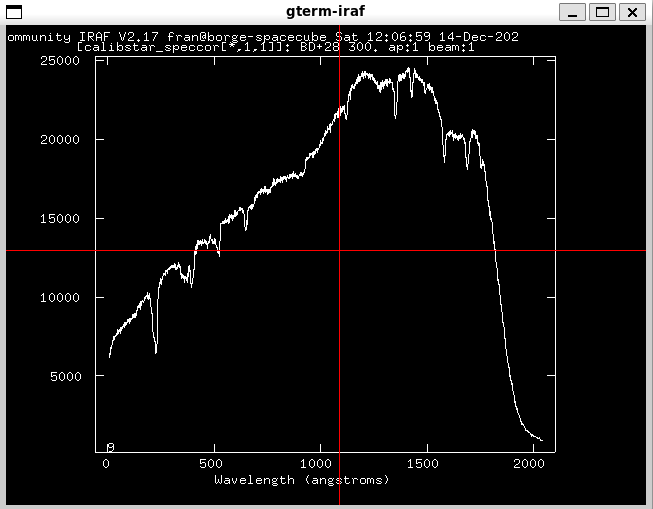

Now, for the flux calibration, we use the following command:
```
noao
imred
kpnoslit
epar standard
```

We use the following parameters:
```
images = calibstar_speccor
output = std
caldir = onedstds$spec50cal/
star_nam = bd284211
airmass = EMPTY (will be taken from file header)
exptime = EMPTY (will be taken from file header)
```

**Note:** To check header contents: `imhead filename.fits long+` from which we can find:
```
AIRMASS = 1.111 / Telescope airmass at start<br>
EXPTIME =               300.00 / [s] Exposure time
```

And get the following:

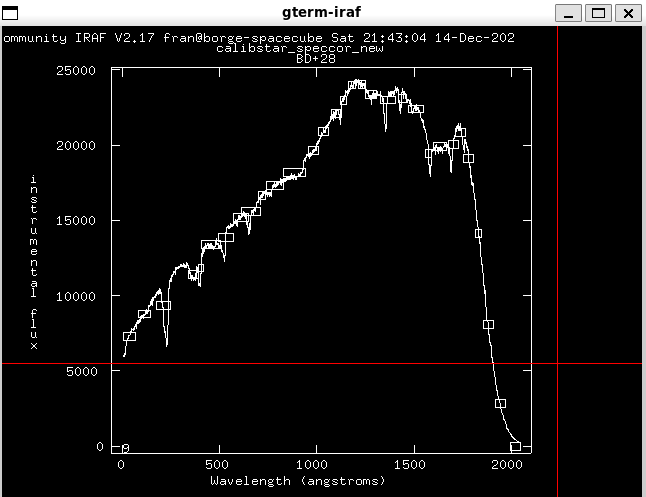

**ii. Fitting the sensitivity function**

Command:

```
noao
imred
kpnoslit
epar sensfunc
```

Parameters:
```
standard = std
sensitiv = sens
functio = spline3
order = 3
```

And can fit the sensitivity function using the following:

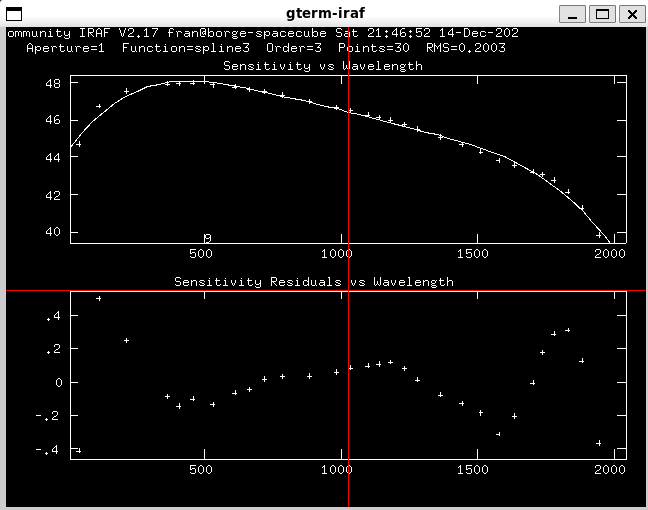

**iii. Applying the flux correction**

The fitted sensitivity function is used to correct the flux within the science targets' spectra.

Use the task:
```
noao
imred
kpnoslit
epar calibrate
```

and the input parameters:
```
input = obj1_speccor
output = obj1_fluxcor
extinct = yes
flux = yes
airmass = EMPTY
exptime = EMPTY
```

and we get the flux-corrected spectrum for object 1:

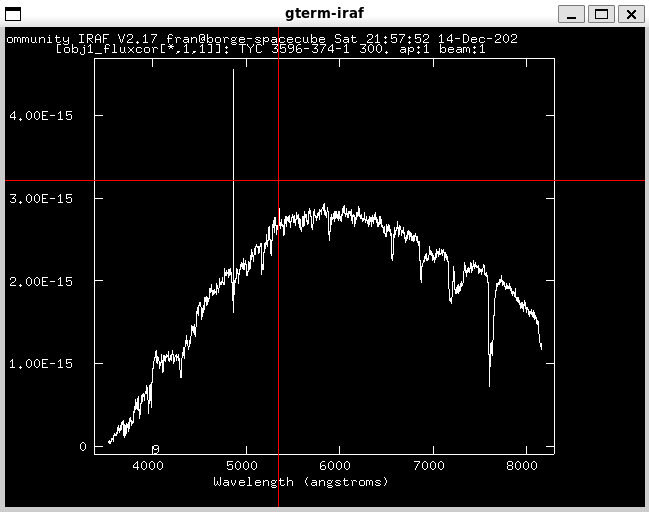

### Correction for interstellar extinction

We need to deredden the wavelengths to remove the effect of extinction due to interstellar matter in the Milky Way.

Use the task:
```
noao
imred
kpnoslit
epar deredden
```

And obtaining the value of the extinction experienced by observations of object 1 from Table 5:
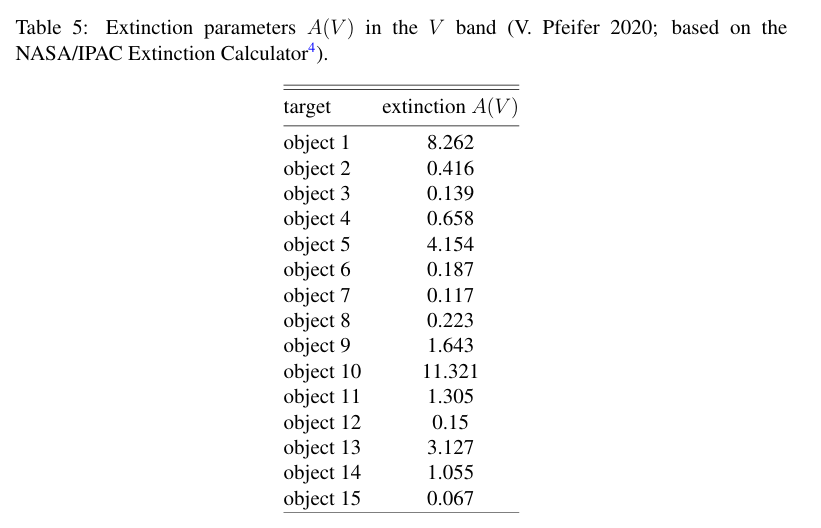

we find: `value = 8.262`

and can use the input parameters:
```
input = obj1_fluxcor
output = obj1_dered
value = 8.262
R = 3.1
type = A(V)
```

We obtain now the dereddened flux-corrected spectrum:

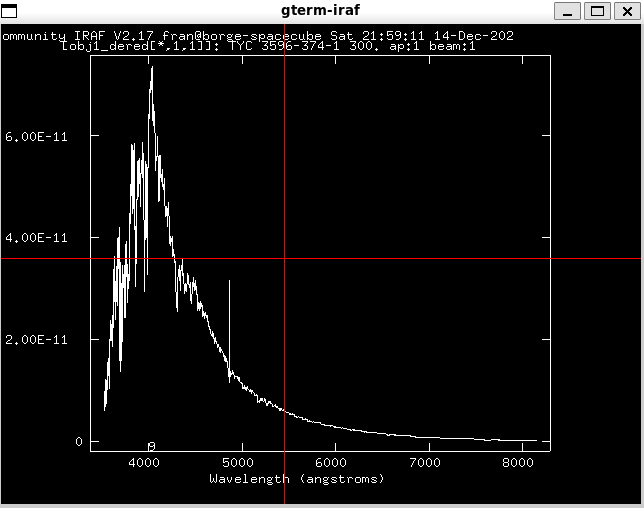

# Appendix

## Copernico-coded.txt

|FILENAME        | OBJECT                    | DATE-OBS               | MJD           | LAMP       | EXPOSURE   | SLIT WIDTH   | AIRMASS  |
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
|AF507042.fits   | BIAS                      | 2018-09-17T17:59:51.0  |  58378.749895 | NO         |        0.0 | NONE         |    1.431 |
AF507043.fits   | BIAS                      | 2018-09-17T17:59:56.8  |  58378.749963 | NO         |        0.0 | NONE         |    1.431 
AF507044.fits   | BIAS                      | 2018-09-17T18:00:02.6  |   58378.75003 | NO         |        0.0 | NONE         |    1.431 
AF507045.fits   | BIAS                      | 2018-09-17T18:00:08.6  |    58378.7501 | NO         |        0.0 | NONE         |    1.431 
AF507046.fits   | BIAS                      | 2018-09-17T18:00:14.5  |  58378.750168 | NO         |        0.0 | NONE         |    1.431 
AF507047.fits   | BIAS                      | 2018-09-17T18:00:20.3  |  58378.750235 | NO         |        0.0 | NONE         |    1.431 
AF507048.fits   | BIAS                      | 2018-09-17T18:00:26.5  |  58378.750307 | NO         |        0.0 | NONE         |    1.431 
AF507049.fits   | BIAS                      | 2018-09-17T18:00:32.4  |  58378.750375 | NO         |        0.0 | NONE         |    1.431 
AF507050.fits   | BIAS                      | 2018-09-17T18:00:38.3  |  58378.750443 | NO         |        0.0 | NONE         |    1.431 
AF507051.fits   | BIAS                      | 2018-09-17T18:00:44.2  |  58378.750511 | NO         |        0.0 | NONE         |    1.431 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507052.fits   | TEST                      | 2018-09-17T18:17:21.3  |  58378.762053 | Ne         |       30.0 | 1.69         |    1.431 
AF507053.fits   | TEST                      | 2018-09-17T18:17:57.9  |  58378.762476 | Ne         |       30.0 | 1.69         |    1.431 
AF507054.fits   | TEST                      | 2018-09-17T18:18:34.9  |  58378.762904 | Ne         |       30.0 | 1.69         |    1.431 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507055.fits   | ARCHGCD                   | 2018-09-17T18:23:27.4  |  58378.766289 | HgCd       |       60.0 | 1.69         |    1.431 
AF507056.fits   | ARCHGCD                   | 2018-09-17T18:24:34.0  |   58378.76706 | HgCd       |       60.0 | 1.69         |    1.431 
AF507057.fits   | ARCHGCD                   | 2018-09-17T18:25:40.6  |  58378.767831 | HgCd       |       60.0 | 1.69         |    1.431 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507058.fits   | FLAT                      | 2018-09-17T18:38:04.4  |  58378.776439 | NO         |        8.0 | 1.69         |    1.434 
AF507059.fits   | FLAT                      | 2018-09-17T18:38:19.0  |  58378.776609 | NO         |        8.0 | 1.69         |    1.434 
AF507060.fits   | FLAT                      | 2018-09-17T18:38:33.6  |  58378.776778 | NO         |        8.0 | 1.69         |    1.434 
AF507061.fits   | FLAT                      | 2018-09-17T18:38:48.3  |  58378.776948 | NO         |        8.0 | 1.69         |    1.434 
AF507062.fits   | FLAT                      | 2018-09-17T18:39:03.0  |  58378.777118 | NO         |        8.0 | 1.69         |    1.434 
AF507063.fits   | FLAT                      | 2018-09-17T18:39:17.6  |  58378.777287 | NO         |        8.0 | 1.69         |    1.434 
AF507064.fits   | FLAT                      | 2018-09-17T18:39:32.3  |  58378.777457 | NO         |        8.0 | 1.69         |    1.434 
AF507065.fits   | FLAT                      | 2018-09-17T18:39:46.9  |  58378.777627 | NO         |        8.0 | 1.69         |    1.434 
AF507066.fits   | FLAT                      | 2018-09-17T18:40:01.6  |  58378.777797 | NO         |        8.0 | 1.69         |    1.434 
AF507067.fits   | FLAT                      | 2018-09-17T18:40:16.3  |  58378.777966 | NO         |        8.0 | 1.69         |    1.434 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507068.fits   | BD+28                     | 2018-09-17T19:39:28.6  |  58378.819081 | NO         |      300.0 | 4.22         |    1.111 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507069.fits   | Object1                   | 2018-09-17T20:06:07.4  |  58378.837586 | NO         |      300.0 | 1.69         |    1.004 
AF507070.fits   | Object1                   | 2018-09-17T20:12:30.4  |  58378.842018 | NO         |      300.0 | 1.69         |    1.003 
AF507071.fits   | Object1                   | 2018-09-17T20:17:55.9  |  58378.845786 | NO         |      600.0 | 1.69         |    1.002 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507072.fits   | Object2                   | 2018-09-17T20:46:15.8  |   58378.86546 | NO         |      600.0 | 1.69         |    1.048 
AF507073.fits   | Object2                   | 2018-09-17T20:59:13.2  |  58378.874458 | NO         |      600.0 | 1.69         |    1.048 
AF507074.fits   | Object2                   | 2018-09-17T21:09:20.9  |  58378.881492 | NO         |      600.0 | 1.69         |    1.049 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507075.fits   | Object3                   | 2018-09-17T21:37:01.5  |  58378.900712 | NO         |      600.0 | 1.69         |    1.123 
AF507076.fits   | Object3                   | 2018-09-17T21:49:52.7  |  58378.909638 | NO         |      600.0 | 1.69         |    1.123 
AF507077.fits   | Object3                   | 2018-09-17T22:00:00.5  |  58378.916672 | NO         |      600.0 | 1.69         |    1.126 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507078.fits   | Object4                   | 2018-09-17T22:23:33.0  |  58378.933021 | NO         |      600.0 | 1.69         |    1.009 
AF507079.fits   | Object4                   | 2018-09-17T22:35:12.1  |  58378.941112 | NO         |      300.0 | 1.69         |    1.012 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507080.fits   | Object5                   | 2018-09-17T22:56:09.4  |  58378.955664 | NO         |      600.0 | 1.69         |    1.038 
AF507081.fits   | Object5                   | 2018-09-17T23:09:35.6  |  58378.964996 | NO         |      600.0 | 1.69         |    1.034 
AF507082.fits   | Object5                   | 2018-09-17T23:19:43.5  |  58378.972031 | NO         |      600.0 | 1.69         |    1.031 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507083.fits   | Object6_AQUISITION        | 2018-09-17T23:36:57.6  |     58378.984 | NO         |        3.0 | NONE         |    1.221 
AF507084.fits   | Object6_AQUISITION        | 2018-09-17T23:38:06.0  |  58378.984791 | NO         |        3.0 | NONE         |    1.219 
AF507085.fits   | Object6_AQUISITION        | 2018-09-17T23:38:55.2  |  58378.985361 | NO         |        3.0 | NONE         |    1.218 
AF507086.fits   | Object6_AQUISITION        | 2018-09-17T23:39:55.9  |  58378.986064 | NO         |        3.0 | NONE         |    1.216 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507087.fits   | Object6_SLIT              | 2018-09-17T23:41:12.1  |  58378.986946 | NO         |        3.0 | 1.69         |    1.214 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507088.fits   | Object6_SPECTRUM          | 2018-09-17T23:42:41.3  |  58378.987978 | NO         |      600.0 | 1.69         |    1.212 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507089.fits   | Object6_SLIT              | 2018-09-18T00:36:49.1  |  58379.025568 | NO         |        3.0 | NONE         |     1.16 
AF507090.fits   | Object6_SLIT              | 2018-09-18T00:38:14.9  |  58379.026561 | NO         |        3.0 | NONE         |    1.159 
AF507091.fits   | Object6_SLIT              | 2018-09-18T00:39:41.8  |  58379.027567 | NO         |        3.0 | NONE         |    1.159 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507092.fits   | Object6_SPECTRUM          | 2018-09-18T00:41:28.2  |  58379.028798 | NO         |      600.0 | 1.69         |    1.158 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507093.fits   | Object6_SLIT              | 2018-09-18T00:51:44.1  |  58379.035927 | NO         |        3.0 | 1.69         |    1.155 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507094.fits   | Object6_SPECTRUM          | 2018-09-18T00:52:02.9  |  58379.036145 | NO         |      600.0 | 1.69         |    1.155 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507095.fits   | Object6_SLIT              | 2018-09-18T01:02:19.9  |  58379.043286 | NO         |        3.0 | 1.69         |    1.154 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507096.fits   | Object6_SPECTRUM          | 2018-09-18T01:03:15.9  |  58379.043935 | NO         |      600.0 | 1.69         |    1.154 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507097.fits   | Object7_SLIT              | 2018-09-18T01:20:13.7  |  58379.055714 | NO         |        3.0 | NONE         |    1.026 
AF507098.fits   | Object7_SLIT              | 2018-09-18T01:21:54.0  |  58379.056875 | NO         |        3.0 | NONE         |    1.026 
AF507099.fits   | Object7_SLIT              | 2018-09-18T01:23:51.2  |  58379.058232 | NO         |        3.0 | NONE         |    1.027 
AF507100.fits   | Object7_SLIT              | 2018-09-18T01:25:37.0  |  58379.059456 | NO         |        3.0 | 1.69         |    1.027 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507101.fits   | Object7                   | 2018-09-18T01:26:47.9  |  58379.060277 | NO         |      600.0 | 1.69         |    1.027 
AF507102.fits   | Object7                   | 2018-09-18T01:36:54.7  |  58379.067299 | NO         |      600.0 | 1.69         |    1.031 
AF507103.fits   | Object7                   | 2018-09-18T01:47:11.0  |  58379.074432 | NO         |      600.0 | 1.69         |    1.035 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507104.fits   | Object8_AQUISITION        | 2018-09-18T02:04:25.8  |   58379.08641 | NO         |        3.0 | NONE         |    1.002 
AF507105.fits   | Object8_AQUISITION        | 2018-09-18T02:08:35.9  |  58379.089304 | NO         |        3.0 | NONE         |    1.003 
AF507106.fits   | Object8_AQUISITION        | 2018-09-18T02:11:21.4  |   58379.09122 | NO         |        3.0 | NONE         |    1.003 
AF507107.fits   | Object8_SLITIMAGE         | 2018-09-18T02:15:06.0  |  58379.093819 | NO         |        3.0 | 1.69         |    1.004 
|---        | ---                    | ---               | ---           | ---       | ---   | ---   | ---|  
AF507108.fits   | Object8-SPECTRUM          | 2018-09-18T02:17:39.8  |    58379.0956 | NO         |      600.0 | 1.69         |    1.005 
AF507109.fits   | Object8-SPECTRUM          | 2018-09-18T02:28:37.9  |  58379.103216 | NO         |      600.0 | 1.69         |    1.008 
AF507110.fits   | Object8-SPECTRUM          | 2018-09-18T02:38:45.9  |  58379.110254 | NO         |      600.0 | 1.69         |    1.013

# References

- [Task 11: Spectroscopy - Data Reduction and
Interpretation
A. Kaminski, J. Heidt, V. Pfeifer
March 5, 2021
](https://www.lsw.uni-heidelberg.de/users/jheidt/praktikum/Astrolab_material/Task11/Task11.pdf)

- [ An introduction to analysis of single dispersion spectra with IRAF](https://www.astrogeo.va.it/ans_spectroscopy/asiago_iraf_tutorial.pdf)